In [1]:
from eppy.modeleditor import IDF
import glob
import pandas as pd
import numpy as np
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pyumi as pu
import logging as lg

In [2]:
pu.config(log_console=True, log_file=True, log_level=lg.INFO)
# Create logger
# logger = lg.getLogger()
# logger.setLevel(lg.DEBUG)
# logger.debug('test')

List of idf files to parse

In [3]:
files = glob.glob("../data/necb/NECB_2011_Montreal_idf/*.idf")
files

['../data/necb/NECB_2011_Montreal_idf/NECB 2011-HighriseApartment-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf',
 '../data/necb/NECB_2011_Montreal_idf/NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf',
 '../data/necb/NECB_2011_Montreal_idf/NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf',
 '../data/necb/NECB_2011_Montreal_idf/NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf',
 '../data/necb/NECB_2011_Montreal_idf/NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf',
 '../data/necb/NECB_2011_Montreal_idf/NECB 2011-FullServiceRestaurant-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw.idf']

The following takes the lisf of idf files and uses the `eppy.modeleditor` package to parse the EnergyPlus objects

In [4]:
idfs = pu.load_idf(files, openstudio_version='2.6.0')

/Applications/OpenStudio-2.6.0/EnergyPlus/Energy+.idd


Then we create a list of archtype names. These keys are used on the `object_from_idfs` function. Uncomment the last line and rerun cell to show.

In [5]:
keys = [idf.idfobjects['BUILDING'][0].Name for idf in idfs]
keys

['NECB 2011-HighriseApartment-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 13:16:17 +0000',
 'NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 14:03:31 +0000',
 'NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 15:40:21 +0000',
 'NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 14:12:57 +0000',
 'NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 13:41:30 +0000',
 'NECB 2011-FullServiceRestaurant-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 12:56:38 +0000']

In [6]:
import json
components = {}
for umi_dict in pu.load_umi_template('../data/BostonTemplateLibrary.json'):
    for x in umi_dict:
#         print(umi_dict[x].columns.tolist())
        components[x] = umi_dict[x].columns.tolist()
with open('umi_components_attributes.txt', 'w') as file:
     file.write(json.dumps(components, indent=4))       

In [7]:
# pu.convert_necb_to_umi_json(idfs)

## GasMaterials

In [8]:
GasMaterials = pu.object_from_idfs(idfs, 'WINDOWMATERIAL:GAS', keys)

In [9]:
GasMaterials

,Name,Archetype,Gas_Type,Thickness,key
$id,,,,,
0,AIR 13MM,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Air,0.0127,WindowMaterial:Gas
1,AIR 6MM,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Air,0.0063,WindowMaterial:Gas


In [10]:
GasMaterials['Cost'] = 0
GasMaterials['EmbodiedCarbon'] = 0
GasMaterials['EmbodiedCarbonStdDev'] = 0
GasMaterials['EmbodiedEnergy'] = 0
GasMaterials['EmbodiedEnergyStdDev'] = 0
GasMaterials['SubstitutionRatePattern'] = np.NaN # ! Might have to change to an empty array
GasMaterials['SubstitutionTimestep'] = 0
GasMaterials['TransportCarbon'] = 0
GasMaterials['TransportDistance'] = 0
GasMaterials['TransportEnergy'] = 0
GasMaterials['Life'] = 1 # Todo: What does Life mean? Alwats 1 in Boston Template
GasMaterials['Comment'] = ''
GasMaterials['DataSource'] = GasMaterials['Archetype']

In [11]:
def gas_type(row):
    if 'air' in row['Gas_Type'].lower():
        return 0
    elif 'argon' in row['Gas_Type']:
        return 1
    elif 'krypton' in row['Gas_Type'].lower():
        return 2
    elif 'xenon' in row['Gas_Type'].lower():
        return 3
    elif 'sf6' in row['Gas_Type'].lower():
        return 4

In [12]:
# Add GasType Column based on previous function
GasMaterials['GasType'] = GasMaterials.apply(lambda x: gas_type(x), axis=1)

In [13]:
GasMaterials.rename(columns={'Gas_Type':'Type'},inplace=True)

In [14]:
gasmaterials_columns = ["GasType",
      "Type",
      "EmbodiedEnergy",
      "EmbodiedEnergyStdDev",
      "EmbodiedCarbon",
      "EmbodiedCarbonStdDev",
      "Cost",
      "Life",
      "SubstitutionRatePattern",
      "SubstitutionTimestep",
      "TransportCarbon",
      "TransportDistance",
      "TransportEnergy",
      "Comment",
      "DataSource",
      "Name"]

In [15]:
GasMaterials = GasMaterials[gasmaterials_columns].copy()

In [16]:
def newrange(previous, following):
    From = previous.iloc[[-1]].index.values + 1
    To = From + len(following)
    return np.arange(From, To)

## GlazingMaterials

#### WindowMaterial

In [17]:
WindowMaterial_Glazing = pu.object_from_idfs(idfs, 'WINDOWMATERIAL:GLAZING', keys)

In [18]:
column_rename = {'Optical_Data_Type':'Optical',
                'Window_Glass_Spectral_Data_Set_Name':'OpticalData',
                'Solar_Transmittance_at_Normal_Incidence':'SolarTransmittance',
                'Front_Side_Solar_Reflectance_at_Normal_Incidence':'SolarReflectanceFront',
                'Back_Side_Solar_Reflectance_at_Normal_Incidence':'SolarReflectanceBack',
                'Infrared_Transmittance_at_Normal_Incidence':'IRTransmittance',
                'Visible_Transmittance_at_Normal_Incidence':'VisibleTransmittance',
                'Front_Side_Visible_Reflectance_at_Normal_Incidence':'VisibleReflectanceFront',
                'Back_Side_Visible_Reflectance_at_Normal_Incidence':'VisibleReflectanceBack',
                'Front_Side_Infrared_Hemispherical_Emissivity':'IREmissivityFront',
                'Back_Side_Infrared_Hemispherical_Emissivity':'IREmissivityBack',
                'Dirt_Correction_Factor_for_Solar_and_Visible_Transmittance':'DirtFactor'}

In [19]:
GlazingMaterials = WindowMaterial_Glazing
GlazingMaterials.rename(columns=column_rename, inplace=True)
GlazingMaterials = GlazingMaterials.drop(['key', 'Solar_Diffusing'], axis=1)
GlazingMaterials['Comment'] = 'default'
GlazingMaterials['Cost'] = 0
GlazingMaterials['DataSource'] = GlazingMaterials.pop('Archetype')
GlazingMaterials['Density'] = 2500
GlazingMaterials['EmbodiedCarbon'] = 0
GlazingMaterials['EmbodiedCarbonStdDev'] = 0
GlazingMaterials['EmbodiedEnergy'] = 0
GlazingMaterials['EmbodiedEnergyStdDev'] = 0
GlazingMaterials['Life'] = 1
GlazingMaterials['SubstitutionRatePattern'] = np.NaN # ! Might have to change to an empty array
GlazingMaterials['SubstitutionTimestep'] = 0
GlazingMaterials['TransportCarbon'] = 0
GlazingMaterials['TransportDistance'] = 0
GlazingMaterials['TransportEnergy'] = 0
GlazingMaterials['Type'] = 'Uncoated' # TODO Further investigation necessary

In [20]:
GlazingMaterials.index = newrange(GasMaterials, GlazingMaterials)
GlazingMaterials.index.rename('$id', inplace=True)
GlazingMaterials

,Name,IREmissivityBack,SolarReflectanceBack,VisibleReflectanceBack,Conductivity,DirtFactor,IREmissivityFront,SolarReflectanceFront,VisibleReflectanceFront,IRTransmittance,...,EmbodiedCarbonStdDev,EmbodiedEnergy,EmbodiedEnergyStdDev,Life,SubstitutionRatePattern,SubstitutionTimestep,TransportCarbon,TransportDistance,TransportEnergy,Type
$id,,,,,,,,,,,,,,,,,,,,,
2,CLEAR 6MM,0.840,0.071,0.080,0.9000,1.0,0.840,0.0710,0.0800,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
3,Clear 3mm,0.840,0.075,0.081,0.9000,1.0,0.840,0.0750,0.0810,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
4,LoE TINT 6MM,0.100,0.200,0.054,0.9000,1.0,0.840,0.0930,0.0350,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
5,REF D CLEAR 6MM,0.820,0.379,0.505,0.9000,1.0,0.840,0.3080,0.4530,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
6,REF D TINT 6MM,0.820,0.360,0.450,0.9000,1.0,0.840,0.1400,0.1800,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
7,Theoretical Glass [167],0.985,0.000,0.000,2.1073,1.0,0.985,0.7126,0.6988,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
8,Theoretical Glass [197],0.900,0.000,0.000,0.0415,1.0,0.900,0.7151,0.6988,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
9,Theoretical Glass [202],0.900,0.000,0.000,0.0192,1.0,0.900,0.7175,0.6308,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated
10,Theoretical Glass [207],0.900,0.000,0.000,0.0133,1.0,0.900,0.6189,0.5100,0.0,...,0,0,0,1,NaN,0,0,0,0,Uncoated


#### WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM

In [21]:
WindowMaterialsSimpleGlaze = pu.object_from_idfs(idfs, 'WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM', keys)

In [22]:
SimpleGlazing = WindowMaterialsSimpleGlaze.apply(lambda row: pu.simple_glazing(row['Solar_Heat_Gain_Coefficient'], row['UFactor'], row['Visible_Transmittance']), axis=1).apply(pd.Series)
SimpleGlazing.loc[:,'Name'] = WindowMaterialsSimpleGlaze['Name']
SimpleGlazing.loc[:,'DataSource'] = 'EnergyPlus Simple Glazing Calculation'

In [23]:
SimpleGlazing

,Conductivity,Thickness,SolarTransmittance,SolarReflectanceFront,SolarReflectanceBack,IRTransmittance,VisibleTransmittance,VisibleReflectanceFront,VisibleReflectanceBack,IREmissivityFront,...,Life,SubstitutionRatePattern,SubstitutionTimestep,TransportCarbon,TransportDistance,TransportEnergy,Type,Comment,Name,DataSource
$id,,,,,,,,,,,,,,,,,,,,,
0,0.119925,0.033827,0.524293,0.292167,0.292167,0.0,0.21,0.170637,0.262461,0.84,...,1,NaN,0,0,0,0,Uncoated,Properties calculated from Simple Glazing System,Customized Fenestration:: cond=0.220 tvis=0.22...,EnergyPlus Simple Glazing Calculation
1,0.119925,0.033827,0.524293,0.292167,0.292167,0.0,0.21,0.170637,0.262461,0.84,...,1,NaN,0,0,0,0,Uncoated,Properties calculated from Simple Glazing System,Customized Fenestration:: cond=0.220 tvis=0.29...,EnergyPlus Simple Glazing Calculation
2,0.119925,0.033827,0.524293,0.292167,0.292167,0.0,0.21,0.170637,0.262461,0.84,...,1,NaN,0,0,0,0,Uncoated,Properties calculated from Simple Glazing System,Customized Fenestration:: cond=0.220 tvis=0.44...,EnergyPlus Simple Glazing Calculation
3,0.119925,0.033827,0.524293,0.292167,0.292167,0.0,0.21,0.170637,0.262461,0.84,...,1,NaN,0,0,0,0,Uncoated,Properties calculated from Simple Glazing System,Customized Fenestration:: cond=0.220 tvis=0.89...,EnergyPlus Simple Glazing Calculation


In [24]:
GlazingMaterials = GlazingMaterials.append(SimpleGlazing, ignore_index=True, sort=True)

In [25]:
GlazingMaterials

,Comment,Conductivity,Cost,DataSource,Density,DirtFactor,EmbodiedCarbon,EmbodiedCarbonStdDev,EmbodiedEnergy,EmbodiedEnergyStdDev,...,SubstitutionRatePattern,SubstitutionTimestep,Thickness,TransportCarbon,TransportDistance,TransportEnergy,Type,VisibleReflectanceBack,VisibleReflectanceFront,VisibleTransmittance
0,default,0.900000,0,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2500,1.0,0,0,0,0,...,NaN,0,0.006000,0,0,0,Uncoated,0.080000,0.080000,0.8810
1,default,0.900000,0,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.081000,0.081000,0.8980
2,default,0.900000,0,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2500,1.0,0,0,0,0,...,NaN,0,0.006000,0,0,0,Uncoated,0.054000,0.035000,0.5000
3,default,0.900000,0,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2500,1.0,0,0,0,0,...,NaN,0,0.006000,0,0,0,Uncoated,0.505000,0.453000,0.3340
4,default,0.900000,0,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2500,1.0,0,0,0,0,...,NaN,0,0.006000,0,0,0,Uncoated,0.450000,0.180000,0.2500
5,default,2.107300,0,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.000000,0.698800,0.2512
6,default,0.041500,0,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.000000,0.698800,0.2512
7,default,0.019200,0,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.000000,0.630800,0.3192
8,default,0.013300,0,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.000000,0.510000,0.4400
9,default,0.013300,0,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,2500,1.0,0,0,0,0,...,NaN,0,0.003000,0,0,0,Uncoated,0.000000,0.442100,0.5079


In [26]:
GlazingMaterials.index = newrange(GasMaterials, GlazingMaterials)
GlazingMaterials.index.rename('$id', inplace=True)

In [27]:
GlazingMaterials.iloc[14]

Comment                     Properties calculated from Simple Glazing System
Conductivity                                                        0.119925
Cost                                                                       0
DataSource                             EnergyPlus Simple Glazing Calculation
Density                                                                 2500
DirtFactor                                                                 1
EmbodiedCarbon                                                             0
EmbodiedCarbonStdDev                                                       0
EmbodiedEnergy                                                             0
EmbodiedEnergyStdDev                                                       0
IREmissivityBack                                                        0.84
IREmissivityFront                                                       0.84
IRTransmittance                                                            0

## OpaqueMaterials

In [28]:
# MASS
MaterialsMass = pu.object_from_idfs(idfs, 'MATERIAL', keys)
MaterialsMass

,Name,Archetype,Conductivity,Density,Roughness,Solar_Absorptance,Specific_Heat,Thermal_Absorptance,Thickness,Visible_Absorptance,key
$id,,,,,,,,,,,
0,1/2IN Gypsum,NECB 2011-HighriseApartment-NECB HDD Method-CA...,0.1600,784.90,Smooth,0.40,830.0,0.90,0.0127,0.40,Material
1,1/2IN Gypsum 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,0.1600,784.90,Smooth,0.40,830.0,0.90,0.0127,0.40,Material
2,100mm Normalweight concrete floor,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2.3100,2322.00,MediumSmooth,0.70,832.0,0.90,0.1016,0.70,Material
3,1IN Stucco,NECB 2011-HighriseApartment-NECB HDD Method-CA...,0.6918,1858.00,Smooth,0.70,837.0,0.90,0.0253,0.92,Material
4,1IN Stucco 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,0.6918,1858.00,Smooth,0.70,837.0,0.90,0.0253,0.92,Material
5,4 in. Normalweight Concrete Floor,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2.3100,2322.00,MediumRough,0.70,832.0,0.90,0.1016,0.70,Material
6,4 in. Normalweight Concrete Floor 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2.3100,2322.00,MediumRough,0.70,832.0,0.90,0.1016,0.70,Material
7,6 in. Normalweight Concrete Floor,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2.3100,2322.00,MediumRough,0.70,832.0,0.90,0.1524,0.70,Material
8,6 in. Normalweight Concrete Floor 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,2.3100,2322.00,MediumRough,0.70,832.0,0.90,0.1524,0.70,Material


In [29]:
MaterialNoMass = pu.object_from_idfs(idfs, 'MATERIAL:NOMASS', keys)
MaterialNoMass

,Name,Archetype,Roughness,Solar_Absorptance,Thermal_Absorptance,Thermal_Resistance,Visible_Absorptance,key
$id,,,,,,,,
0,CP02 CARPET PAD,NECB 2011-HighriseApartment-NECB HDD Method-CA...,VeryRough,0.7,0.9,0.216480,0.8,Material:NoMass
1,CP02 CARPET PAD 1,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,VeryRough,0.7,0.9,0.216480,0.8,Material:NoMass
2,Nonres_Floor_Insulation,NECB 2011-HighriseApartment-NECB HDD Method-CA...,MediumSmooth,0.7,0.9,2.882920,0.7,Material:NoMass
3,Typical Carpet Pad,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,0.216480,0.8,Material:NoMass
4,Typical Carpet Pad 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,0.216480,0.8,Material:NoMass
5,Typical Carpet Pad 2,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,1.255030,0.8,Material:NoMass
6,Typical Carpet Pad 3,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,3.455153,0.8,Material:NoMass
7,Typical Insulation R-0.58,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,0.101875,0.7,Material:NoMass
8,Typical Insulation R-0.58 1,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Smooth,0.7,0.9,0.454528,0.7,Material:NoMass


In [30]:
OpaqueMaterials = pd.concat([MaterialsMass,MaterialNoMass], sort=True, ignore_index=True)
OpaqueMaterials.index = newrange(GlazingMaterials, OpaqueMaterials)
OpaqueMaterials.index.name = '$id'

In [31]:
column_rename = {'Solar_Absorptance':'SolarAbsorptance',
                'Specific_Heat':'SpecificHeat', 
                'Thermal_Absorptance':'ThermalEmittance',
                'Thermal_Resistance':'ThermalResistance',
                'Visible_Absorptance':'VisibleAbsorptance'}

In [32]:
OpaqueMaterials.rename(columns=column_rename, inplace=True)

In [33]:
OpaqueMaterials['Comment'] = 'default'
OpaqueMaterials['Cost'] = 0
OpaqueMaterials['DataSource'] = OpaqueMaterials.pop('Archetype')
OpaqueMaterials['EmbodiedCarbon'] = 0
OpaqueMaterials['EmbodiedCarbonStdDev'] = 0
OpaqueMaterials['EmbodiedEnergy'] = 0
OpaqueMaterials['EmbodiedEnergyStdDev'] = 0
OpaqueMaterials['Life'] = 1
OpaqueMaterials['MoistureDiffusionResistance'] = 50
OpaqueMaterials['PhaseChange'] = False
OpaqueMaterials['PhaseChangeProperties'] = '' # ! Further investigation needed
OpaqueMaterials['SubstitutionRatePattern'] = np.NaN # ! Might have to change to an empty array
OpaqueMaterials['SubstitutionTimestep'] = 0
OpaqueMaterials['TransportCarbon'] = 0
OpaqueMaterials['TransportDistance'] = 0
OpaqueMaterials['TransportEnergy'] = 0
OpaqueMaterials['Type'] = '' # ! Further investigation necessary
OpaqueMaterials['VariableConductivity'] = False
OpaqueMaterials['VariableConductivityProperties'] = np.NaN # ! Further investigation necessary

In [34]:
OpaqueMaterials = OpaqueMaterials.drop(['key'], axis=1)

In [35]:
OpaqueMaterials

,Conductivity,Density,Name,Roughness,SolarAbsorptance,SpecificHeat,ThermalEmittance,ThermalResistance,Thickness,VisibleAbsorptance,...,PhaseChange,PhaseChangeProperties,SubstitutionRatePattern,SubstitutionTimestep,TransportCarbon,TransportDistance,TransportEnergy,Type,VariableConductivity,VariableConductivityProperties
$id,,,,,,,,,,,,,,,,,,,,,
17,0.1600,784.90,1/2IN Gypsum,Smooth,0.40,830.0,0.90,NaN,0.0127,0.40,...,False,,NaN,0,0,0,0,,False,NaN
18,0.1600,784.90,1/2IN Gypsum 1,Smooth,0.40,830.0,0.90,NaN,0.0127,0.40,...,False,,NaN,0,0,0,0,,False,NaN
19,2.3100,2322.00,100mm Normalweight concrete floor,MediumSmooth,0.70,832.0,0.90,NaN,0.1016,0.70,...,False,,NaN,0,0,0,0,,False,NaN
20,0.6918,1858.00,1IN Stucco,Smooth,0.70,837.0,0.90,NaN,0.0253,0.92,...,False,,NaN,0,0,0,0,,False,NaN
21,0.6918,1858.00,1IN Stucco 1,Smooth,0.70,837.0,0.90,NaN,0.0253,0.92,...,False,,NaN,0,0,0,0,,False,NaN
22,2.3100,2322.00,4 in. Normalweight Concrete Floor,MediumRough,0.70,832.0,0.90,NaN,0.1016,0.70,...,False,,NaN,0,0,0,0,,False,NaN
23,2.3100,2322.00,4 in. Normalweight Concrete Floor 1,MediumRough,0.70,832.0,0.90,NaN,0.1016,0.70,...,False,,NaN,0,0,0,0,,False,NaN
24,2.3100,2322.00,6 in. Normalweight Concrete Floor,MediumRough,0.70,832.0,0.90,NaN,0.1524,0.70,...,False,,NaN,0,0,0,0,,False,NaN
25,2.3100,2322.00,6 in. Normalweight Concrete Floor 1,MediumRough,0.70,832.0,0.90,NaN,0.1524,0.70,...,False,,NaN,0,0,0,0,,False,NaN


## OpaqueConstructions

In [36]:
# Thermal Resistance : (m2-K)/W
# Conductivity : W/(m-K)

In [37]:
Constructions = pu.object_from_idfs(idfs, 'CONSTRUCTION', keys)

In [38]:
Constructions

,Name,Archetype,Layer_2,Layer_3,Layer_4,Outside_Layer,key
$id,,,,,,,
0,Basement Floor construction,NECB 2011-HighriseApartment-NECB HDD Method-CA...,CP02 CARPET PAD,NaN,NaN,M10 200mm concrete block basement wall,Construction
1,Basement Wall construction,NECB 2011-HighriseApartment-NECB HDD Method-CA...,NaN,NaN,NaN,M10 200mm concrete block basement wall,Construction
2,Customized Fenestration: cond=0.220 tvis=0.220...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,NaN,NaN,NaN,Customized Fenestration:: cond=0.220 tvis=0.22...,Construction
3,Customized Fenestration: cond=0.220 tvis=0.294...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,NaN,NaN,NaN,Customized Fenestration:: cond=0.220 tvis=0.29...,Construction
4,Customized Fenestration: cond=0.220 tvis=0.441...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,NaN,NaN,NaN,Customized Fenestration:: cond=0.220 tvis=0.44...,Construction
5,Customized Fenestration: cond=0.220 tvis=0.898...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,NaN,NaN,NaN,Customized Fenestration:: cond=0.220 tvis=0.89...,Construction
6,Customized opaque construction {0033cb2d-2078-...,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction
7,Customized opaque construction {058cb932-e200-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Typical Insulation R-0.58 1,NaN,NaN,F08 Metal surface 1,Construction
8,Customized opaque construction {0978471f-1a2b-...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Typical Insulation R-0.58 1,NaN,NaN,F08 Metal surface 1,Construction


In [39]:
OpaqueConstructions = pu.object_from_idfs(idfs, 'BUILDINGSURFACE:DETAILED', keys)

In [40]:
OpaqueConstructions = OpaqueConstructions.merge(Constructions, left_on='Construction_Name', right_on='Name')

OpaqueConstructions = OpaqueConstructions.groupby('Construction_Name').first()
OpaqueConstructions.reset_index(inplace=True)
OpaqueConstructions

,Construction_Name,Name_x,Archetype_x,Number_of_Vertices,Outside_Boundary_Condition,Outside_Boundary_Condition_Object,Sun_Exposure,Surface_Type,Vertex_10_Xcoordinate,Vertex_10_Ycoordinate,...,Wind_Exposure,Zone_Name,key_x,Name_y,Archetype_y,Layer_2,Layer_3,Layer_4,Outside_Layer,key_y
0,Customized opaque construction {0033cb2d-2078-...,Banquet_Flr_6_Wall_North,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,WindExposed,Sp-Banquet_Flr_6 Sys-3 Flr-4 Sch-B HPlcmt-nort...,BuildingSurface:Detailed,Customized opaque construction {0033cb2d-2078-...,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction
1,Customized opaque construction {1292baf7-9fd7-...,Dining_Wall_East,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,WindExposed,Sp-Dining Sys-3 Flr-1 Sch-B HPlcmt-south ZN,BuildingSurface:Detailed,Customized opaque construction {1292baf7-9fd7-...,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction
2,Customized opaque construction {26c5182d-92b0-...,Building_Roof,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,WindExposed,Sp-TopFloor_Plenum Sys-0 Flr-4 Sch-- undefined...,BuildingSurface:Detailed,Customized opaque construction {26c5182d-92b0-...,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction
3,Customized opaque construction {3a0bc7d3-1520-...,Bath_ZN_1_FLR_1_Ceiling,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,WindExposed,Sp-Bath_ZN_1_FLR_1 Sys-3 Flr-1 Sch-D HPlcmt-we...,BuildingSurface:Detailed,Customized opaque construction {3a0bc7d3-1520-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction
4,Customized opaque construction {47144b0f-1dcc-...,Bath_ZN_1_FLR_1_Wall_5,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,WindExposed,Sp-Bath_ZN_1_FLR_1 Sys-3 Flr-1 Sch-D HPlcmt-we...,BuildingSurface:Detailed,Customized opaque construction {47144b0f-1dcc-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction
5,Customized opaque construction {4b8be161-d6b6-...,g Floor C,NECB 2011-HighriseApartment-NECB HDD Method-CA...,,Ground,,NoSun,Floor,NaN,NaN,...,NoWind,Sp-G Corridor Sys-1 Flr-5 Sch-G HPlcmt-east ZN,BuildingSurface:Detailed,Customized opaque construction {4b8be161-d6b6-...,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Typical Carpet Pad 2,NaN,NaN,6 in. Normalweight Concrete Floor 1,Construction
6,Customized opaque construction {5504b548-ed58-...,DataCenter_basement_ZN_6_Wall_North,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,,Ground,,NoSun,Wall,NaN,NaN,...,NoWind,Sp-DataCenter_basement_ZN_6 Sys-6 Flr-2 Sch-A ...,BuildingSurface:Detailed,Customized opaque construction {5504b548-ed58-...,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Typical Carpet Pad 3,NaN,NaN,6 in. Normalweight Concrete Floor 2,Construction
7,Customized opaque construction {5504b548-ed58-...,DataCenter_basement_ZN_6_Floor,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,,Ground,,NoSun,Floor,NaN,NaN,...,NoWind,Sp-DataCenter_basement_ZN_6 Sys-6 Flr-2 Sch-A ...,BuildingSurface:Detailed,Customized opaque construction {5504b548-ed58-...,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Typical Carpet Pad 2,NaN,NaN,6 in. Normalweight Concrete Floor 1,Construction
8,Customized opaque construction {70a08f41-941f-...,F2 EWall C,NECB 2011-HighriseApartment-NECB HDD Method-CA...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,WindExposed,Sp-F2 Corridor Sys-1 Flr-7 Sch-G HPlcmt-east ZN,BuildingSurface:Detailed,Customized opaque construction {70a08f41-941f-...,NEC

In [41]:
def label_surface(row):
    """
    This function adds the umi-Category column
    """
    # Floors
    if row['Surface_Type'] == 'Floor':
        if row['Outside_Boundary_Condition'] == 'Surface':
            return 'Interior Floor'
        if row['Outside_Boundary_Condition'] == 'Ground':
            return 'Ground Floor'
        if row['Outside_Boundary_Condition'] == 'Outdoors':
            return 'Exterior Floor'
        else:
            return 'Other'
        
    # Roofs & Ceilings
    if row['Surface_Type'] == 'Roof':
        return 'Roof'
    if row['Surface_Type'] == 'Ceiling':
        return 'Interior Floor'
    # Walls
    if row['Surface_Type'] == 'Wall':
        if row['Outside_Boundary_Condition'] == 'Surface':
            return 'Partition'
        if row['Outside_Boundary_Condition'] == 'Outdoors':
            return 'Facade'
    return 'Other'

In [42]:
def type_surface(row):
    """
    This function adds the umi-Type column
    """
    # Floors
    if row['Surface_Type'] == 'Floor':
        if row['Outside_Boundary_Condition'] == 'Surface':
            return 3
        if row['Outside_Boundary_Condition'] == 'Ground':
            return 2
        if row['Outside_Boundary_Condition'] == 'Outdoors':
            return 4
        else:
            return np.NaN
        
    # Roofs & Ceilings
    if row['Surface_Type'] == 'Roof':
        return 1
    if row['Surface_Type'] == 'Ceiling':
        return 3
    # Walls
    if row['Surface_Type'] == 'Wall':
        if row['Outside_Boundary_Condition'] == 'Surface':
            return 5
        if row['Outside_Boundary_Condition'] == 'Outdoors':
            return 0
    return np.NaN

In [43]:
OpaqueConstructions['Category'] = OpaqueConstructions.apply(lambda x: label_surface(x), axis=1)
OpaqueConstructions['Type'] = OpaqueConstructions.apply(lambda x: type_surface(x), axis=1)

In [44]:
# Lets group by `Construction_Name` to get a list of unique `Surface_Type` and `Outside_Boundary_Condition`.

OpaqueConstructions = OpaqueConstructions.groupby('Construction_Name').first().reset_index()
OpaqueConstructions.head()

,Construction_Name,Name_x,Archetype_x,Number_of_Vertices,Outside_Boundary_Condition,Outside_Boundary_Condition_Object,Sun_Exposure,Surface_Type,Vertex_10_Xcoordinate,Vertex_10_Ycoordinate,...,key_x,Name_y,Archetype_y,Layer_2,Layer_3,Layer_4,Outside_Layer,key_y,Category,Type
0,Customized opaque construction {0033cb2d-2078-...,Banquet_Flr_6_Wall_North,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,BuildingSurface:Detailed,Customized opaque construction {0033cb2d-2078-...,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0
1,Customized opaque construction {1292baf7-9fd7-...,Dining_Wall_East,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,BuildingSurface:Detailed,Customized opaque construction {1292baf7-9fd7-...,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0
2,Customized opaque construction {26c5182d-92b0-...,Building_Roof,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,BuildingSurface:Detailed,Customized opaque construction {26c5182d-92b0-...,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction,Roof,1.0
3,Customized opaque construction {3a0bc7d3-1520-...,Bath_ZN_1_FLR_1_Ceiling,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,BuildingSurface:Detailed,Customized opaque construction {3a0bc7d3-1520-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction,Roof,1.0
4,Customized opaque construction {47144b0f-1dcc-...,Bath_ZN_1_FLR_1_Wall_5,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,BuildingSurface:Detailed,Customized opaque construction {47144b0f-1dcc-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0


In [45]:
def layer_composition(row, df):
    # Assumes 10 max layers
    layers = []
    
    # Let's start with the `Outside_Layer`
    ref, thickness = get_row_prop(row, df, 'Outside_Layer', 'Thickness')
    if thickness:
        layers.append({'Material':{'$ref':ref,'thickness':thickness}})
    else:
        thickness = 0.001 # Very small tickness
        layers.append({'Material':{'$ref':ref,'thickness':thickness}})
    # Then we iterate over the other layers. The number of layers is unknow. Limited to 10 for now
    for i in range(1,10):
        try:
            layer_name = 'Layer_{}'.format(i)
            ref, thickness = get_row_prop(row, df, layer_name, 'Thickness')
            if thickness:
                layers.append({'Material':{'$ref':ref,'thickness':thickness}})
            else:
                thickness = 0.001 # Very small tickness
                layers.append({'Material':{'$ref':ref,'thickness':thickness}})
        except:
            pass #
    return layers

In [46]:
def get_row_prop(row, df, column_name, prop):
    layer = df.loc[df['Name'] == row[column_name]]
    ref = layer.index[0]
    prop = layer[prop].values[0] # Very small tickness
    return ref, prop

In [47]:
OpaqueConstructions['Layers'] = OpaqueConstructions.apply(lambda x: layer_composition(x, OpaqueMaterials), axis=1)

In [48]:
OpaqueConstructions.head()

,Construction_Name,Name_x,Archetype_x,Number_of_Vertices,Outside_Boundary_Condition,Outside_Boundary_Condition_Object,Sun_Exposure,Surface_Type,Vertex_10_Xcoordinate,Vertex_10_Ycoordinate,...,Name_y,Archetype_y,Layer_2,Layer_3,Layer_4,Outside_Layer,key_y,Category,Type,Layers
0,Customized opaque construction {0033cb2d-2078-...,Banquet_Flr_6_Wall_North,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,Customized opaque construction {0033cb2d-2078-...,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0,"[{'Material': {'$ref': 21, 'thickness': 0.0253..."
1,Customized opaque construction {1292baf7-9fd7-...,Dining_Wall_East,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,Customized opaque construction {1292baf7-9fd7-...,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0,"[{'Material': {'$ref': 21, 'thickness': 0.0253..."
2,Customized opaque construction {26c5182d-92b0-...,Building_Roof,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,Customized opaque construction {26c5182d-92b0-...,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction,Roof,1.0,"[{'Material': {'$ref': 43, 'thickness': 0.0007..."
3,Customized opaque construction {3a0bc7d3-1520-...,Bath_ZN_1_FLR_1_Ceiling,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Roof,NaN,NaN,...,Customized opaque construction {3a0bc7d3-1520-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Typical Insulation R-19.63 1,NaN,NaN,Metal Roof Surface 1,Construction,Roof,1.0,"[{'Material': {'$ref': 43, 'thickness': 0.0007..."
4,Customized opaque construction {47144b0f-1dcc-...,Bath_ZN_1_FLR_1_Wall_5,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,,Outdoors,,SunExposed,Wall,NaN,NaN,...,Customized opaque construction {47144b0f-1dcc-...,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,8IN CONCRETE HW RefBldg 1,Typical Insulation R-10.11 1,1/2IN Gypsum 1,1IN Stucco 1,Construction,Facade,0.0,"[{'Material': {'$ref': 21, 'thickness': 0.0253..."


In [49]:
OpaqueConstructions['AssemblyCarbon'] = 0
OpaqueConstructions['AssemblyCost'] = 0
OpaqueConstructions['AssemblyEnergy'] = 0
OpaqueConstructions['Comments'] = 'default'
OpaqueConstructions['DataSource'] = OpaqueConstructions.pop('Archetype_x')
OpaqueConstructions['DisassemblyCarbon'] = 0
OpaqueConstructions['DisassemblyEnergy'] = 0

In [50]:
columns = ['Layers','Type','AssemblyCarbon','AssemblyCost',
           'AssemblyEnergy','DisassemblyCarbon','DisassemblyEnergy',
           'Category','Comments','DataSource','Construction_Name']

OpaqueConstructions = OpaqueConstructions[columns]

OpaqueConstructions = OpaqueConstructions.rename(columns={'Construction_Name':'Name'})

In [51]:
OpaqueConstructions.index = newrange(OpaqueMaterials,OpaqueConstructions)
OpaqueConstructions.index.name = '$id'

In [52]:
OpaqueConstructions

,Layers,Type,AssemblyCarbon,AssemblyCost,AssemblyEnergy,DisassemblyCarbon,DisassemblyEnergy,Category,Comments,DataSource,Name
$id,,,,,,,,,,,
75,"[{'Material': {'$ref': 21, 'thickness': 0.0253...",0.0,0,0,0,0,0,Facade,default,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,Customized opaque construction {0033cb2d-2078-...
76,"[{'Material': {'$ref': 21, 'thickness': 0.0253...",0.0,0,0,0,0,0,Facade,default,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,Customized opaque construction {1292baf7-9fd7-...
77,"[{'Material': {'$ref': 43, 'thickness': 0.0007...",1.0,0,0,0,0,0,Roof,default,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Customized opaque construction {26c5182d-92b0-...
78,"[{'Material': {'$ref': 43, 'thickness': 0.0007...",1.0,0,0,0,0,0,Roof,default,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Customized opaque construction {3a0bc7d3-1520-...
79,"[{'Material': {'$ref': 21, 'thickness': 0.0253...",0.0,0,0,0,0,0,Facade,default,NECB 2011-PrimarySchool-NECB HDD Method-CAN_PQ...,Customized opaque construction {47144b0f-1dcc-...
80,"[{'Material': {'$ref': 25, 'thickness': 0.1524...",2.0,0,0,0,0,0,Ground Floor,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Customized opaque construction {4b8be161-d6b6-...
81,"[{'Material': {'$ref': 26, 'thickness': 0.1524...",NaN,0,0,0,0,0,Other,default,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Customized opaque construction {5504b548-ed58-...
82,"[{'Material': {'$ref': 25, 'thickness': 0.1524...",2.0,0,0,0,0,0,Ground Floor,default,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Customized opaque construction {5504b548-ed58-...
83,"[{'Material': {'$ref': 21, 'thickness': 0.0253...",0.0,0,0,0,0,0,Facade,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Customized opaque construction {70a08f41-941f-...


# WindowConstructions

In [53]:
WindowConstructions = pu.object_from_idfs(idfs, 'FENESTRATIONSURFACE:DETAILED', keys)
WindowConstructions = WindowConstructions.merge(Constructions, left_on='Construction_Name', right_on='Name')
WindowConstructions = WindowConstructions.groupby('Construction_Name', as_index=False).first()
WindowConstructions.index = newrange(OpaqueConstructions, WindowConstructions)
WindowConstructions.index.name = '$id'
WindowConstructions = WindowConstructions[['Construction_Name', 'Archetype_x', 'Outside_Layer']]

In [54]:
WindowConstructions.loc[:,'AssemblyCarbon'] = 0
WindowConstructions.loc[:,'AssemblyCost'] = 0
WindowConstructions.loc[:,'AssemblyEnergy'] = 0
WindowConstructions.loc[:,'Category'] = 'Single'
WindowConstructions.loc[:,'Type'] = 2
WindowConstructions.loc[:,'Comments'] = 'default'
WindowConstructions.loc[:,'DataSource'] = WindowConstructions.pop('Archetype_x')
WindowConstructions.loc[:,'DisassemblyCarbon'] = 0
WindowConstructions.loc[:,'DisassemblyEnergy'] = 0

In [55]:
WindowConstructions['Layers'] = WindowConstructions.apply(lambda x: layer_composition(x, GlazingMaterials), axis=1)

In [56]:
WindowConstructions.rename(columns={'Construction_Name':'Name'}, inplace=True)

In [57]:
WindowConstructions.drop(columns=['Outside_Layer'], inplace=True)

In [58]:
WindowConstructions

,Name,AssemblyCarbon,AssemblyCost,AssemblyEnergy,Category,Type,Comments,DataSource,DisassemblyCarbon,DisassemblyEnergy,Layers
$id,,,,,,,,,,,
99,Customized Fenestration: cond=0.220 tvis=0.220...,0.0,0.0,0.0,Single,2.0,default,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,0.0,0.0,"[{'Material': {'$ref': 13, 'thickness': 0.0338..."


# DaySchedules

In [59]:
from datetime import datetime, timedelta

In [60]:
DaySchedules = pu.object_from_idfs(idfs, 'SCHEDULE:DAY:INTERVAL', keys)
DaySchedules.index = newrange(WindowConstructions, DaySchedules)
DaySchedules.index.name = '$id'

In [61]:
DaySchedules

,Name,Archetype,Interpolate_to_Timestep,Schedule_Type_Limits_Name,Time_1,Time_10,Time_11,Time_12,Time_13,Time_14,...,Value_Until_Time_23,Value_Until_Time_24,Value_Until_Time_3,Value_Until_Time_4,Value_Until_Time_5,Value_Until_Time_6,Value_Until_Time_7,Value_Until_Time_8,Value_Until_Time_9,key
$id,,,,,,,,,,,,,,,,,,,,,
100,Air Velocity Schedule Default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Velocity,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
101,Always On Default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Fractional,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
102,Clothing Schedule Default Winter Clothes,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Any Number,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
103,Clothing Schedule Summer Clothes,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Any Number,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
104,Economizer Max OA Fraction 100 pct Default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
105,Make-up air unit Occ Sch Default,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Fractional,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
106,Make-up air unit Occ Sch Friday,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Fractional,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
107,Make-up air unit Occ Sch Monday,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Fractional,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval
108,Make-up air unit Occ Sch Saturday,NECB 2011-HighriseApartment-NECB HDD Method-CA...,No,Fractional,24:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schedule:Day:Interval


In [62]:
def my_to_datetime(date_str):
    if date_str[0:2] != '24':
        return datetime.strptime(date_str, '%H:%M') - timedelta(hours=1)
    return datetime.strptime('23:00', '%H:%M')

In [63]:
def time2time(row):
    time_seg = []
    for i in range(1,25):
        time = row['Time_{}'.format(i)] # Time_i
        value = row['Value_Until_Time_{}'.format(i)] # Value_Until_Time_i
        if str(time) != 'nan' and str(value) != 'nan':
#             print(time)
            time = my_to_datetime(time).hour
#             print(time)
            times = np.ones(time+1) * float(value)
            time_seg.append(times)
    arrays = time_seg
    array = time_seg[0]
    length = len(arrays[0])
    for i, a in enumerate(arrays):
        if i != 0:
            array = np.append(array, a[length-1:-1])
            length = len(a)
    return array

In [64]:
DaySchedules['Values'] = DaySchedules.apply(lambda x: time2time(x), axis=1)

In [65]:
DaySchedules = DaySchedules.loc[:,['Name', 'Values']]
DaySchedules.loc[:,'Category'] = 'Day'
DaySchedules.loc[:,'Comments'] = 'Comments'
DaySchedules.loc[:,'DataSource'] = 'default'
DaySchedules.loc[:,'Type'] = 'Fraction'
DaySchedules

,Name,Values,Category,Comments,DataSource,Type
$id,,,,,,
100,Air Velocity Schedule Default,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",Day,Comments,default,Fraction
101,Always On Default,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
102,Clothing Schedule Default Winter Clothes,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
103,Clothing Schedule Summer Clothes,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",Day,Comments,default,Fraction
104,Economizer Max OA Fraction 100 pct Default,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
105,Make-up air unit Occ Sch Default,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
106,Make-up air unit Occ Sch Friday,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
107,Make-up air unit Occ Sch Monday,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction
108,Make-up air unit Occ Sch Saturday,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",Day,Comments,default,Fraction


In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

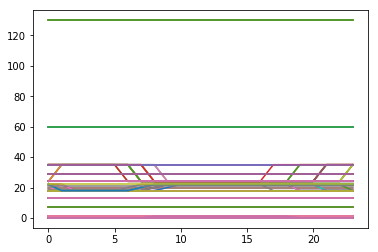

In [67]:
# Plotting the schedules
for aid, grp in DaySchedules.groupby(['Name']):
    plt.plot(grp['Values'].values[0]) 

# WeekSchedule

In [68]:
WeekSchedules = pu.object_from_idfs(idfs, 'SCHEDULE:WEEK:DAILY', keys)

In [69]:
def schedule_composition(row, df):
    # Assumes 7 days
    day_schedules = []
    days = ['Monday_ScheduleDay_Name',
           'Tuesday_ScheduleDay_Name',
           'Wednesday_ScheduleDay_Name',
           'Thursday_ScheduleDay_Name',
           'Friday_ScheduleDay_Name',
           'Saturday_ScheduleDay_Name',
           'Sunday_ScheduleDay_Name'] # With weekends last (as defined in umi-template)
    # Let's start with the `Outside_Layer`
    for day in days:
        try:
            ref, day_schedule = get_row_prop(row, df, day, 'Values')
            day_schedules.append({'$ref':ref})
        except:
            pass
    return day_schedules

In [70]:
WeekSchedules['Values'] = WeekSchedules.apply(lambda x: schedule_composition(x, DaySchedules), axis=1)

In [71]:
WeekSchedules = WeekSchedules.loc[:,['Name','Values','Archetype']]
WeekSchedules.loc[:,'Category'] = 'Week'
WeekSchedules.loc[:,'Comments'] = 'default'
WeekSchedules.loc[:,'DataSource'] = WeekSchedules.pop('Archetype')
WeekSchedules.loc[:,'Type'] = 'Fraction'

In [72]:
WeekSchedules.index = newrange(DaySchedules, WeekSchedules)
WeekSchedules.index.name = '$id'
WeekSchedules

,Name,Values,Category,Comments,DataSource,Type
$id,,,,,,
1247,Air Velocity Schedule Week Rule - Jan1-Dec31,"[{'$ref': 100}, {'$ref': 100}, {'$ref': 100}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1248,Always On Week Rule - Jan1-Dec31,"[{'$ref': 101}, {'$ref': 101}, {'$ref': 101}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1249,CHW Temp Week Rule - Jan1-Dec31,"[{'$ref': 1242}, {'$ref': 1242}, {'$ref': 1242...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1250,CW Temp Week Rule - Jan1-Dec31,"[{'$ref': 1244}, {'$ref': 1244}, {'$ref': 1244...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1251,Clothing Schedule Week Rule - Jan1-Dec31,"[{'$ref': 102}, {'$ref': 102}, {'$ref': 102}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1252,Economizer Max OA Fraction 100 pct Week Rule -...,"[{'$ref': 104}, {'$ref': 104}, {'$ref': 104}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1253,NECB-A-Electric-Equipment Week Rule - Jan1-Dec31,"[{'$ref': 117}, {'$ref': 117}, {'$ref': 117}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1254,NECB-A-Lighting Week Rule - Jan1-Dec31,"[{'$ref': 121}, {'$ref': 121}, {'$ref': 121}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction
1255,NECB-A-Occupancy Week Rule - Jan1-Dec31,"[{'$ref': 125}, {'$ref': 125}, {'$ref': 125}, ...",Week,default,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Fraction


# YearSchedules

In [73]:
YearSchedules = pu.object_from_idfs(idfs, 'SCHEDULE:YEAR', keys)

In [74]:
def year_parts(row, df):
    # Maximum of 26 weekly schedules
    parts = []
    for i in range(1, 26 + 1):
        try:
            ref, prop = get_row_prop(row, df, 'ScheduleWeek_Name_{}'.format(i), 'Name')
            fromday = row['Start_Day_{}'.format(i)]
            frommonth = row['Start_Month_{}'.format(i)]
            today = row['End_Day_{}'.format(i)]
            tomonth = row['End_Month_{}'.format(i)]
            parts.append({'FromDay': fromday,
                          'FromMonth': frommonth,
                          'Schedule': {'$ref': ref},
                          'ToDay': today,
                          'ToMonth': tomonth})
        except:
            continue
    return parts

In [75]:
YearSchedules['Parts'] = YearSchedules.apply(lambda x: year_parts(x, WeekSchedules), axis=1)

In [76]:
YearSchedules = YearSchedules[['Name', 'Schedule_Type_Limits_Name','Parts','Archetype']].copy()

YearSchedules['Category'] = 'Year'
YearSchedules['Comments'] = 'default'
YearSchedules['DataSource'] = YearSchedules.pop('Archetype')

YearSchedules.index = newrange(WeekSchedules, YearSchedules)
YearSchedules.index.name = '$id'
YearSchedules

,Name,Schedule_Type_Limits_Name,Parts,Category,Comments,DataSource
$id,,,,,,
2059,Air Velocity Schedule,Velocity,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2060,Always On,Fractional,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2061,CHW Temp,TEMPERATURE 1,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2062,CW Temp,TEMPERATURE 2,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2063,Clothing Schedule,Any Number,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2064,Economizer Max OA Fraction 100 pct,,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2065,Make-up air unit Occ Sch,Fractional,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2066,Makeup-Air Unit Supply Air Temp,Temperature,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...
2067,NECB-A-Electric-Equipment,Fractional,"[{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...",Year,default,NECB 2011-HighriseApartment-NECB HDD Method-CA...


In [77]:
YearSchedules.set_index('Name').loc['NECB-B-Occupancy']['Parts']

[{'FromDay': 1,
  'FromMonth': 1,
  'Schedule': {'$ref': 1857},
  'ToDay': 31,
  'ToMonth': 12}]

# Start of json READ

At this point, the needed information is easier to acces in the `qacq` files (json format)

In [78]:
import json

In [79]:
files = glob.glob("../data/necb/NECB_2011_Montreal/*.json")

In [80]:
# Reading the json as a dict
qaqcs = []
for file in files:
    with open(file) as json_data:
        qaqcs.append(json.load(json_data))

all_qaqcs = {}
for qaqc in qaqcs:
    qaqc_dfs = {}
    name = qaqc['building']['name']
    for key in qaqc.keys():
        if isinstance(qaqc[key], dict):
            try:
                qaqc_dfs[key] = pd.DataFrame.from_dict(qaqc[key])
            except Exception as inst:
                qaqc_dfs[key] = pd.DataFrame.from_dict([qaqc[key]])
        elif isinstance(qaqc[key], list):
            qaqc_dfs[key] = pd.DataFrame.from_dict(qaqc[key])
        else:
            qaqc_dfs[key] = qaqc[key]
    all_qaqcs[name] = qaqc_dfs

# Zones

Zones can be identified by the term `horzontal_placement` (north, south, east, west, core) in the NECB building definition [https://github.com/NREL/OpenStudio-Prototype-Buildings/blob/master/lib/btap/measures/btap_equest_converter/compliance.rb]

In [81]:
def iscore(row):
    """
    Helps to group by core and perimeter zones
    """
    if 'core' in row['thermal_zone'].lower(): # We look for the string `core` in the Zone_Name
        return 'Core'
    else:
        return 'Perimeter'

In [82]:
Zones = []
for qaqc in all_qaqcs.values():
    Zone = qaqc['spaces']
    Zones.append(Zone)
Zones = pd.concat(Zones, keys=all_qaqcs.keys(), names=['Archetype','$id'], sort=True)
Zones['Space_Type'] = Zones.apply(lambda x: iscore(x), axis=1)

In [83]:
Zones

breathing_zone_outdoor_airflow_vbz  \
Archetype                                          $id                                       
NECB 2011-RetailStripmall-NECB HDD Method-CAN_P... 0                                0.2062   
                                                   1                                0.4124   
                                                   2                                0.4124   
                                                   3                                0.2062   
                                                   4                                0.2062   
                                                   5                                0.2062   
                                                   6                                0.2062   
                                                   7                                0.2062   
                                                   8                                0.2062   
                                                   9                                0.2062   
NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr... 0                                0.0053   
                                                   1                                0.0850   
                                                   2                                0.3186   
                                                   3                                0.4161   
                                                   4                                0.7008   
                                                   5                                0.3080   
                                                   6                                0.0425   
                                                   7                                0.1911   
                                                   8                                0.0425   
                                                   9                                0.0850   
                                                   10                               0.0637   
                                                   11                               0.3186   
                                                   12                               1.0194   
                                                   13                               0.0361   
                                                   14                               0.0531   
                                                   15                               0.5784   
                                                   16                               0.1593   
                                                   17                               0.4248   
                                                   18                               0.4318   
                                                   19                               0.0212   
...                                                                                    ...   
NECB 2011-MediumOffice-NECB HDD Method-CAN_PQ_M... 16                               0.0895   
                                                   17                               0.0567   
NECB 2011-SmallOffice-NECB HDD Method-CAN_PQ_Mo... 0                                0.0291   
                                                   1                                0.0646   
                                                   2                                0.0490   
                                                   3                                0.0490   
                                                   4                                0.0291   
                                                   5                               -1.0000   
NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mon... 0                                0.0218   
                                                   1                                0.0501   
              

In [84]:
def ach(row):
    """
    Calculates Air changes per hour (ACH)
    """
    q = row['infiltration_flow_m3_per_s']
    V = row['volume']
    if q > 0:
        return 3600 * q / V
    return np.NaN

In [85]:
# Calculating the infiltration flow by use of the area-infiltration flow times the exterior wall area
Zones['infiltration_flow_m3_per_s'] = Zones['infiltration_flow_per_m2'] * Zones['exterior_wall_area']

In [86]:
Zones['air_changes_per_hour'] = Zones.apply(lambda x: ach(x), axis=1)

In [87]:
# Let's add the space area

spacetype_area_breakdown = []
for qaqc in all_qaqcs.values():
    area = qaqc['spacetype_area_breakdown'].T.rename(columns={0:'Space_Area'})
    spacetype_area_breakdown.append(area)
spacetype_area_breakdown = pd.concat(spacetype_area_breakdown, axis=0, keys=all_qaqcs.keys(), names=['Archetype','space_type_name'], sort=True)

In [88]:
Zones['space_type_name'] = Zones['space_type_name'].str.replace(' ','_').str.lower()

In [89]:
Zones = Zones.reset_index().set_index(['Archetype','space_type_name']).merge(spacetype_area_breakdown, left_index=True, right_index=True, how='left')
Zones = Zones.reset_index().set_index(['Archetype','$id'])

In [90]:
Zones.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521 entries, (NECB 2011-FullServiceRestaurant-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 12:56:38 +0000, 1) to (NECB 2011-Warehouse-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 17:04:58 +0000, 1)
Data columns (total 19 columns):
space_type_name                       521 non-null object
breathing_zone_outdoor_airflow_vbz    521 non-null float64
electric_w_per_m2                     440 non-null float64
exterior_wall_area                    521 non-null float64
infiltration_flow_per_m2              521 non-null float64
infiltration_method                   521 non-null object
lighting_w_per_m2                     512 non-null float64
multiplier                            521 non-null int64
name                                  521 non-null object
occ_per_m2                            512 non-null float64
occupancy_schedule                    512 non-null object
shw_m3_per_s  

In [91]:
# Let's add the `waterUseEquipment` as columns instead of the object they are in the DataFrame.
# To do this, we merge a new dataframe that is created with the apply(pd.Series) function. This transforms
# the dict stucture of each rows into the different columns. We apply the Pd.Series function twice because
# the dicts are inside a list.

Zones = Zones.join(Zones['waterUseEquipment']
                   .apply(pd.Series)[0]
                   .apply(pd.Series)
                   .add_prefix('waterUseEquipment.')).drop(columns=['waterUseEquipment.0','waterUseEquipment']).copy()

/Users/samuelduchesne/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:69: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
/Users/samuelduchesne/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


In [92]:
Zones.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521 entries, (NECB 2011-FullServiceRestaurant-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 12:56:38 +0000, 1) to (NECB 2011-Warehouse-NECB HDD Method-CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw created: 2017-06-30 17:04:58 +0000, 1)
Data columns (total 21 columns):
space_type_name                              521 non-null object
breathing_zone_outdoor_airflow_vbz           521 non-null float64
electric_w_per_m2                            440 non-null float64
exterior_wall_area                           521 non-null float64
infiltration_flow_per_m2                     521 non-null float64
infiltration_method                          521 non-null object
lighting_w_per_m2                            512 non-null float64
multiplier                                   521 non-null int64
name                                         521 non-null object
occ_per_m2                                   512 non-null float64
oc

In [93]:
def weighted_mean(series):
    """
    Evaluates a weighteed average while ignoring NaNs
    """
    index = ~np.isnan(series)
    if np.any(index):
        weights=Zones.loc[series.index, 'volume'] * Zones.loc[series.index, 'multiplier']
        weights=weights[index]
        a = series[index]
        return np.average(a, weights=weights)
    return 0

In [94]:
def my_agg(x):
    names = {
        'Amount mean': x['Amount'].mean(),
        'Amount std':  x['Amount'].std(),
        'Amount range': x['Amount'].max() - x['Amount'].min(),
        'Score Max':  x['Score'].max(),
        'Score Sum': x['Score'].sum(),
        'Amount Score Sum': (x['Amount'] * x['Score']).sum()}

    return pd.Series(names, index=['Amount range', 'Amount std', 'Amount mean',
                                   'Score Sum', 'Score Max', 'Amount Score Sum'])

In [95]:
# Define a lambda function to compute the weighted mean:
# wm = lambda x: np.average(~np.isnan(x), weights=(Zones.loc[x.index, 'volume'] * Zones.loc[x.index, 'multiplier'])[~np.isnan(x)])
wu = lambda x: x.apply(pd.Series)
# Define a dictionary with the functions to apply for a given column:
f = {'air_changes_per_hour': {'weighted_mean' : weighted_mean},
     'occ_per_m2' : {'weighted_mean' : weighted_mean},
     'breathing_zone_outdoor_airflow_vbz' : {'weighted_mean' : weighted_mean},
     'electric_w_per_m2' : {'weighted_mean' : weighted_mean},
     'lighting_w_per_m2' : {'weighted_mean' : weighted_mean},
     'waterUseEquipment.peak_flow_rate_per_area' : {'weighted_mean' : weighted_mean},
     'Space_Area' : {'sum' : 'sum'}
    }

# Groupby and aggregate with your dictionary:
ZonesByType = Zones.groupby(['Archetype','Space_Type'], sort=True).agg(f).reset_index()
ZonesByType['waterUseEquipment.peak_flow_rate_per_area'] = ZonesByType['waterUseEquipment.peak_flow_rate_per_area'] * 36000 # m3/s/m2 to m3/h/m2
ZonesByType

/Users/samuelduchesne/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Archetype,Space_Type,air_changes_per_hour,occ_per_m2,breathing_zone_outdoor_airflow_vbz,electric_w_per_m2,lighting_w_per_m2,waterUseEquipment.peak_flow_rate_per_area,Space_Area
,,,weighted_mean,weighted_mean,weighted_mean,weighted_mean,weighted_mean,weighted_mean,sum
0,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,Core,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
1,NECB 2011-FullServiceRestaurant-NECB HDD Metho...,Perimeter,0.159231,0.086364,1.020437,3.454542,9.900000,0.002004,511.153316
2,NECB 2011-HighriseApartment-NECB HDD Method-CA...,Perimeter,0.145265,0.016678,0.029912,5.031250,5.414638,0.001605,558614.126333
3,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Core,0.000000,0.050000,0.989559,5.906344,12.903407,0.000856,20619.494448
4,NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Mont...,Perimeter,0.123435,0.041651,2.065723,7.783915,12.728030,0.001074,81848.057538
5,NECB 2011-LargeHotel-NECB HDD Method-CAN_PQ_Mo...,Perimeter,0.175892,0.042361,0.868873,2.323131,10.147711,0.002710,51333.195782
6,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Core,0.000000,0.050000,9.032391,7.500000,11.000000,0.000871,261245.710182
7,NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_M...,Perimeter,0.121185,0.042844,-0.128080,6.466419,11.365729,0.000871,568811.798680
8,NECB 2011-MediumOffice-NECB HDD Method-CAN_PQ_...,Core,0.000000,0.050000,0.424700,7.500000,11.000000,0.000871,14946.557686


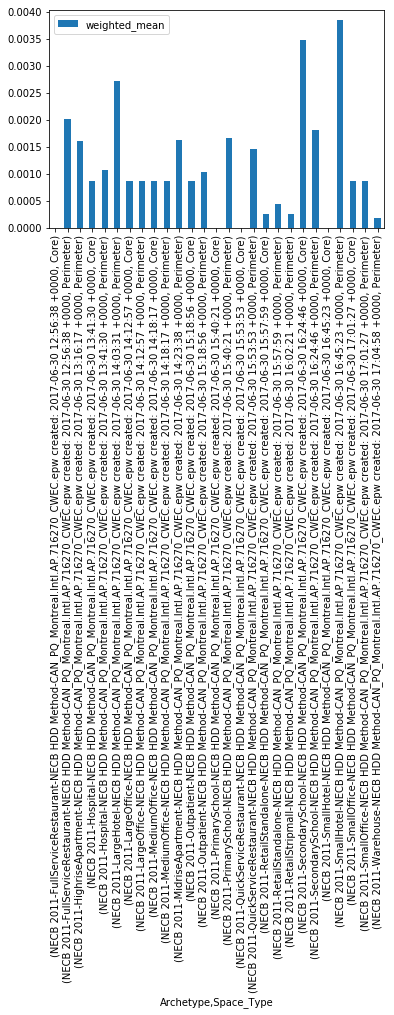

In [96]:
ZonesByType.set_index(['Archetype','Space_Type'])['waterUseEquipment.peak_flow_rate_per_area'].plot(kind='bar')

# DomesticHotWaterSettings

In [97]:
wateruse_equipment = pu.object_from_idfs(idfs, 'WATERUSE:EQUIPMENT')
wateruse_equipment.head()

,Name,Cold_Water_Supply_Temperature_Schedule_Name,EndUse_Subcategory,Flow_Rate_Fraction_Schedule_Name,Hot_Water_Supply_Temperature_Schedule_Name,Latent_Fraction_Schedule_Name,Peak_Flow_Rate,Sensible_Fraction_Schedule_Name,Target_Temperature_Schedule_Name,Zone_Name,key
$id,,,,,,,,,,,
0,Banquet_flr_6 Service Water Use 0.32gal/min,,General,NECB-B-Service Water Heating,,Schedule Ruleset 4,0.000020,Schedule Ruleset 3,Schedule Ruleset 5,Sp-Banquet_Flr_6 Sys-3 Flr-4 Sch-B HPlcmt-nort...,WaterUse:Equipment
1,Basement Service Water Use 0.51gal/min,,General,NECB-E-Service Water Heating,,Schedule Ruleset 10,0.000032,Schedule Ruleset 9,Schedule Ruleset 11,Sp-Basement Sys-4 Flr-3 Sch-E HPlcmt-north ZN,WaterUse:Equipment
2,Basement Service Water Use 2.87gal/min,,General,NECB-A-Service Water Heating,,Schedule Ruleset 109,0.000181,Schedule Ruleset 108,Schedule Ruleset 110,Sp-Basement Sys-3 Flr-7 Sch-A HPlcmt-north ZN,WaterUse:Equipment
3,Cafe_flr_1 Service Water Use 0.02gal/min,,General,NECB-C-Service Water Heating,,Schedule Ruleset 16,0.000002,Schedule Ruleset 15,Schedule Ruleset 17,Sp-Cafe_Flr_1 Sys-6 Flr-1 Sch-C HPlcmt-south ZN,WaterUse:Equipment
4,Cafeteria_zn_1_flr_1 Service Water Use 0.24gal...,,General,NECB-C-Service Water Heating,,Schedule Ruleset 4,0.000015,Schedule Ruleset 3,Schedule Ruleset 5,Sp-Cafeteria_ZN_1_FLR_1 Sys-3 Flr-1 Sch-C HPlc...,WaterUse:Equipment


In [98]:
shw_by_zone = Zones.join(wateruse_equipment
              .set_index('Zone_Name')
             .add_prefix('wateruse_equipment.')
             .drop(columns='wateruse_equipment.key'), on='thermal_zone')

In [99]:
shw_by_zone

space_type_name  \
Archetype                                          $id                                           
NECB 2011-FullServiceRestaurant-NECB HDD Method... 1              space_function_-_undefined_-   
                                                   2      space_function_dining_-_family_space   
                                                   0           space_function_food_preparation   
NECB 2011-HighriseApartment-NECB HDD Method-CAN... 2    space_function_corr._<_2.4m_wide-sch-g   
                                                   15   space_function_corr._<_2.4m_wide-sch-g   
                                                   32   space_function_corr._<_2.4m_wide-sch-g   
                                                   39   space_function_corr._<_2.4m_wide-sch-g   
                                                   43   space_function_corr._<_2.4m_wide-sch-g   
                                                   47   space_function_corr._<_2.4m_wide-sch-g   
                                                   52   space_function_corr._<_2.4m_wide-sch-g   
                                                   53   space_function_corr._<_2.4m_wide-sch-g   
                                                   61   space_function_corr._<_2.4m_wide-sch-g   
                                                   80   space_function_corr._<_2.4m_wide-sch-g   
                                                   0           space_function_dwelling_unit(s)   
                                                   1           space_function_dwelling_unit(s)   
                                                   3           space_function_dwelling_unit(s)   
                                                   4           space_function_dwelling_unit(s)   
                                                   5           space_function_dwelling_unit(s)   
                                                   6           space_function_dwelling_unit(s)   
                                                   7           space_function_dwelling_unit(s)   
                                                   8           space_function_dwelling_unit(s)   
                                                   9           space_function_dwelling_unit(s)   
                                                   10          space_function_dwelling_unit(s)   
                                                   11          space_function_dwelling_unit(s)   
                                                   12          space_function_dwelling_unit(s)   
                                                   13          space_function_dwelling_unit(s)   
                                                   14          space_function_dwelling_unit(s)   
                                                   16          space_function_dwelling_unit(s)   
                                                   17          space_function_dwelling_unit(s)   
                                                   18          space_function_dwelling_unit(s)   
...                                                                                        ...   
NECB 2011-SmallHotel-NECB HDD Method-CAN_PQ_Mon... 25          space_function_lobby_-_elevator   
                                                   66         space_function_lounge/recreation   
                                                   65         space_function_office_-_enclosed   
                                                   1             space_function_stairway-sch-f   
                                                   3             space_function_stairway-sch-f   
                                                   4             space_function_stairway-sch-f   
                                                   16            space_function_stairway-sch-f   
                                                   30            space_function_stairway-sch-f   
                                                   32        

In [100]:
parts = YearSchedules.reset_index().set_index('Name').loc['NECB-C-Service Water Heating']['Parts']

In [101]:
parts

[{'FromDay': 1,
  'FromMonth': 1,
  'Schedule': {'$ref': 1839},
  'ToDay': 31,
  'ToMonth': 12}]

In [102]:
week_ids = [part['Schedule']['$ref'] for part in parts]

In [103]:
day_ids = pd.Series([value for value in WeekSchedules.loc[week_ids]['Values']
                     for value in value]).apply(pd.Series)

In [104]:
day_ids.join(DaySchedules, on='$ref')#.Values.apply(pd.Series).mean(axis=0)

,$ref,Name,Values,Category,Comments,DataSource,Type
0,180,NECB-C-Service Water Heating Default|Wkdy Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
1,180,NECB-C-Service Water Heating Default|Wkdy Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
2,180,NECB-C-Service Water Heating Default|Wkdy Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
3,180,NECB-C-Service Water Heating Default|Wkdy Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
4,180,NECB-C-Service Water Heating Default|Wkdy Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
5,181,NECB-C-Service Water Heating Sat Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction
6,182,NECB-C-Service Water Heating Sun|Hol Day,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",Day,Comments,default,Fraction


In [105]:
def get_schedule(x):
    # Get the year schedule
    year = YearSchedules.reset_index().set_index('Name').loc[str(x)]
    # Get the week schedule id
    week_ids = [part['Schedule']['$ref'] for part in year['Parts']] # A year could be formed by different weeks
    week = WeekSchedules.loc[week_ids]['Values']
    day_ids = pd.Series([value for value in week
                         for value in value]).apply(pd.Series)
    days = day_ids.join(DaySchedules, on='$ref')
    return year, week, days

In [106]:
year, week, day = get_schedule('Schedule Ruleset 5')
year

$id                                                                       2304
Schedule_Type_Limits_Name                                                     
Parts                        [{'FromDay': 1, 'FromMonth': 1, 'Schedule': {'...
Category                                                                  Year
Comments                                                               default
DataSource                   NECB 2011-HighriseApartment-NECB HDD Method-CA...
Name: Schedule Ruleset 5, dtype: object

In [107]:
week

$id
1645    [{'$ref': 312}, {'$ref': 312}, {'$ref': 312}, ...
Name: Values, dtype: object

In [108]:
day

,$ref,Name,Values,Category,Comments,DataSource,Type
0,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
1,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
2,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
3,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
4,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
5,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction
6,312,Schedule Day 10,"[60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60....",Day,Comments,default,Fraction


In [109]:
def water_temp_from_schedule(schedule_name):
    if 'nan' in str(schedule_name):
        return np.NaN
    else:
        year, week, day = get_schedule(schedule_name)
        return day['Values'].mean().mean()        

In [110]:
shw_by_zone = shw_by_zone.reset_index().set_index(['wateruse_equipment.Flow_Rate_Fraction_Schedule_Name','Archetype']).sort_index()

In [111]:
shw_by_zone['water_temp'] = shw_by_zone.apply(lambda x: water_temp_from_schedule(x['wateruse_equipment.Target_Temperature_Schedule_Name']), axis=1)

In [112]:
shw_by_zone

$id  \
wateruse_equipment.Flow_Rate_Fraction_Schedule_... Archetype                                                 
NECB-A-Service Water Heating                       NECB 2011-HighriseApartment-NECB HDD Method-CAN...   31   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...    3   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   15   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   45   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   22   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   26   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   44   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   13   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   41   
                                                   NECB 2011-Hospital-NECB HDD Method-CAN_PQ_Montr...   43   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    0   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    1   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    2   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    3   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    5   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    6   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    7   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    8   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...    9   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   11   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   12   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   13   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   14   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   15   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   18   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   19   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   20   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   21   
                                                   NECB 2011-LargeOffice-NECB HDD Method-CAN_PQ_Mo...   22   
                                                   NECB 2011-MediumOffice-NECB HDD Method-CAN_PQ_M...    2   
...                                                                                                    ...   
NaN                                                NECB 2011-SmallHotel-NECB HDD Method-CAN_PQ_Mon...   25   
                                                   NECB 2011-SmallHotel-NECB HDD Method-CAN_PQ_Mon...   66   
                                                   NECB 2011-SmallHotel-NECB HDD Method-CAN_PQ_Mon...   65   
                                                   NECB 2011-SmallHotel-NECB HDD Method-CAN_PQ_Mon...    1   
                                 

In [113]:
# Category
# DataSource
# FlowRatePerFloorArea
# IsOn
# Name
# WaterSchedule.$ref - Source: Probably in idf file
# WaterSupplyTemperature
# WaterTemperatureInlet - Source: Probably in idf file
DomesticHotWaterSettingsColumns = ['Category', 'DataSource', 'FlowRatePerFloorArea', 'IsOn', 'Name',
       'WaterSchedule.$ref', 'WaterSupplyTemperature', 'WaterTemperatureInlet']
# Creating a DataFrame

possibleSchedules = DaySchedules[DaySchedules.Name.str.contains('Service Water Loop Temp', case=False)]

# WaterSchedule.$ref
WaterSchedule_ref = YearSchedules[YearSchedules.Name.str.contains('Service Water Loop Temp', case=False)].index

# WaterSupplyTemperature
waterschedule = DaySchedules.reset_index().set_index('Name').loc[possibleSchedules.Name.values,:]
WaterSupplyTemperature = waterschedule.Values.mean().mean() # the first mean() averages possible multiple schedules, the second mean(gets the value

# WaterTemperatureInlet - Source: Probably in idf file
WaterTemperatureInlet = 8.0 # ! This needs to be investigated

DomesticHotWaterSettings = ZonesByType.loc[:,['Archetype', 'Space_Type','FlowRatePerFloorArea']].copy()
DomesticHotWaterSettings.loc[:,'Category'] = DomesticHotWaterSettings['Space_Type']
DomesticHotWaterSettings.loc[:,'IsOn'] = DomesticHotWaterSettings.apply(lambda x: x['FlowRatePerFloorArea'] > 0, axis=1)
DomesticHotWaterSettings.loc[:,'Name'] = DomesticHotWaterSettings['Archetype'] + '_' + DomesticHotWaterSettings['Space_Type']
DomesticHotWaterSettings.loc[:,'DataSource'] = DomesticHotWaterSettings['Archetype']
DomesticHotWaterSettings.loc[:,'WaterSchedule.$ref'] = WaterSchedule_ref.values[0]
DomesticHotWaterSettings.loc[:,'WaterSupplyTemperature'] = WaterSupplyTemperature
DomesticHotWaterSettings.loc[:,'WaterTemperatureInlet'] = WaterTemperatureInlet
DomesticHotWaterSettings.index = newrange(YearSchedules, DomesticHotWaterSettings)
DomesticHotWaterSettings.index.name = '$id'
DomesticHotWaterSettings = DomesticHotWaterSettings[DomesticHotWaterSettingsColumns]

KeyError: ('FlowRatePerFloorArea', 'occurred at index 0')

In [ ]:
for idf in idfs:
    print(idf.idfobjects[])
    


In [ ]:
DomesticHotWaterSettings

# VentilationSettings

In [ ]:
# 'Afn',
# 'Category',
# 'DataSource',
# 'Infiltration',
# 'IsBuoyancyOn',
# 'IsInfiltrationOn',
# 'IsNatVentOn',
# 'IsScheduledVentilationOn',
# 'IsWindOn',
# 'Name',
# 'NatVentMaxOutdoorAirTemp',
# 'NatVentMaxRelHumidity',
# 'NatVentMinOutdoorAirTemp',
# 'NatVentSchedule.$ref',
# 'NatVentZoneTempSetpoint',
# 'ScheduledVentilationAch',
# 'ScheduledVentilationSchedule.$ref',
# 'ScheduledVentilationSetpoint'

VentilationSettingsSettingsColumns = ['Afn', 'Category', 'DataSource', 'Infiltration', 'IsBuoyancyOn',
       'IsInfiltrationOn', 'IsNatVentOn', 'IsScheduledVentilationOn',
       'IsWindOn', 'Name', 'NatVentMaxOutdoorAirTemp', 'NatVentMaxRelHumidity',
       'NatVentMinOutdoorAirTemp', 'NatVentSchedule.$ref',
       'NatVentZoneTempSetpoint', 'ScheduledVentilationAch',
       'ScheduledVentilationSchedule.$ref', 'ScheduledVentilationSetpoint']

In [ ]:
VentilationSettings = ZonesByType.loc[:,['Archetype', 'Space_Type']].copy()

In [ ]:
VentilationSettings.loc[:,'Infiltration'] = ZonesByType.loc[:,'air_changes_per_hour'].values
VentilationSettings.loc[:,'IsBuoyancyOn'] = True
VentilationSettings['IsInfiltrationOn'] = VentilationSettings.apply(lambda x: x['Infiltration'] > 0, axis=1)
VentilationSettings.loc[:,'IsNatVentOn'] = False
VentilationSettings.loc[:,'IsScheduledVentilationOn'] = False
VentilationSettings.loc[:,'IsWindOn'] = False
VentilationSettings.loc[:,'Name'] = VentilationSettings.loc[:,'Archetype'] + '_' + VentilationSettings.loc[:,'Space_Type']
VentilationSettings.loc[:,'NatVentMaxOutdoorAirTemp'] = 26.0
VentilationSettings.loc[:,'NatVentMaxRelHumidity'] = 80.0
VentilationSettings.loc[:,'NatVentMinOutdoorAirTemp'] = 18.0
VentilationSettings.index = newrange(DomesticHotWaterSettings, VentilationSettings)
VentilationSettings.index.name = '$id'

In [ ]:
VentilationSettings

# ZoneConditionings

In [ ]:
ZoneConditionings = ZonesByType.loc[:,['Archetype', 'Space_Type']]

In [ ]:
ZoneConditionings

In [ ]:
AirLoops = []
for qaqc in all_qaqcs.values():
    AirLoop = qaqc['air_loops']
    AirLoops.append(AirLoop)
AirLoops = pd.concat(AirLoops, keys=all_qaqcs.keys(), names=['Archetype','$id'], sort=True)

In [ ]:
AirLoops = AirLoops.join(AirLoops['cooling_coils'].apply(pd.Series).apply(pd.Series),sort=True)
AirLoops = AirLoops.join(AirLoops['dx_single_speed'].apply(pd.Series)[0].apply(pd.Series), sort=True, rsuffix='_cooling')

In [ ]:
AirLoops = AirLoops.join(AirLoops['economizer'].apply(pd.Series).apply(pd.Series),sort=True, rsuffix='_econ')

In [ ]:
AirLoops = AirLoops.join(AirLoops['heating_coils'].apply(pd.Series)['coil_heating_electric'].apply(pd.Series)[0].apply(pd.Series), rsuffix='_heating_coil', sort=True)
AirLoops

In [ ]:
AirLoops = AirLoops.join(AirLoops['supply_fan'].apply(pd.Series), rsuffix='_supply_fan', sort=True)

In [ ]:
AirLoops.iloc[0]

In [ ]:
ZoneConditionings

In [ ]:
Zones.thermal_zone.apply(pd.Series).stack().reset_index(level=2,drop=True).to_frame('thermal_zones')

In [ ]:
AirLoops.thermal_zone.apply(pd.Series).reset_index().head()

In [ ]:
pd.melt(AirLoops.thermal_zones.apply(pd.Series).reset_index(), 
             id_vars=['Archetype', '$id'],
             value_name='thermal_zone')

In [ ]:
AirLoops = AirLoops.reset_index().set_index(['Archetype', '$id','cop'])

In [ ]:
AirLoops

In [ ]:
(pd.melt(AirLoops.thermal_zones.apply(pd.Series).reset_index(), 
             id_vars=['Archetype', '$id','cop'],
             value_name='thermal_zone')
     .set_index(['Archetype', '$id'])
     .drop('variable', axis=1)
     .dropna()
     .sort_index())